# Neural Network Patient Matching

## Importing Dependencies

In [24]:
import chars2vec
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import itertools
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine as cosine_distance

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


## Loading Pre-Trained Model

In [2]:
c2v_model = chars2vec.load_model('eng_50')

In [25]:
df=pd.read_csv('Generated_Data.csv')

In [26]:
df.head()

name           phone                  address  postalZip  \
0     Yvonne Phua  (833) 925-5254  Ap #437-2699 Sed Street      72001   
1     Vance Pawan  (916) 648-8254  Ap #460-3504 Lorem, Ave      24169   
2     Lila Chande  (725) 517-5611    Ap #592-816 Vitae Rd.      85787   
3      Signe Shaw  1-361-885-3442    Ap #247-1256 Sed, Rd.      63438   
4  Lucian Lambert  1-596-511-3644    401-1079 Senectus Ave      48394   

     region numberrange  
0      Ohio  06-20-2023  
1   Montana  03-07-2024  
2  Virginia  08-10-2023  
3   Florida  03-25-2023  
4   Georgia  12-08-2023

In [27]:
comparison_data=pd.read_csv('augmented_data_with_errors.csv')

In [28]:
comparison_data.head()

name           phone                  address  postalZip region  \
0  Yvonne Phua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
1  YvonnE Phua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
2   Yvonne hua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
3   Yvnne Phua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
4  Yvonne Phau  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   

  appointmentdate  
0      06-20-2023  
1      06-20-2023  
2      20-06-2023  
3      20-06-2023  
4           20-06

## Test NN

In [57]:
def preprocess_name(name):
    return name.strip().lower()

# Apply preprocessing
df['name'] = df['name'].apply(preprocess_name)
comparison_data['name'] = comparison_data['name'].apply(preprocess_name)

# Extract unique names again after preprocessing
names = df['name'].dropna().unique()
comparison_names = comparison_data['name'].dropna().unique()


In [58]:
import itertools
import random

# Create robust synthetic co-occurrence data
def create_cooccurrence_data(names, num_sentences=1000):
    sentences = []
    for _ in range(num_sentences):
        sentence = random.sample(list(names), min(10, len(names)))
        sentences.append(sentence)
    return sentences

sentences = create_cooccurrence_data(names)

# Print example sentences
print(f"Example synthetic sentences: {sentences[:5]}")


Example synthetic sentences: [['shana sehgal', 'hayden perry', 'elton wong', 'leigh zheng', 'ralph scholz', 'vance pawan', 'florence mitchell', 'brian xia', 'molly guzman', 'abbot lehmann'], ['barrett rojas', 'indigo mitchell', 'raya burns', 'uma nigam', 'paki thomson', 'adena warren', 'stacy martin', 'luke pok', 'tanner scott', 'karleigh carter'], ['stuart sethi', 'adrian snyder', 'leigh zheng', 'elton wong', 'kim sehgal', 'harper morgan', 'demetria leng', 'hadassah bell', 'andrew cheng', 'odette lao'], ['martena foster', 'xander turner', 'abbot lehmann', 'tamekah joshi', 'macy cole', 'ayanna williams', 'hayden perry', 'jolie white', 'dolan charan', 'melinda hall'], ['dolan charan', 'cameron morgan', 'hayley ranga', 'constance sanders', 'xander turner', 'tamekah joshi', 'kirsten boyd', 'harper morgan', 'abbot lehmann', 'giacomo aggarwal']]


In [59]:
from gensim.models import Word2Vec

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, sg=0)

# Save the model for future use
model.save("name_embeddings.model")

# Example of a name in the model vocabulary
example_name = names[0]
print(f"Example vector for '{example_name}': {model.wv[example_name]}")


Example vector for 'yvonne phua': [ 0.140781   -0.00431308 -0.32542336 -0.0027643  -0.03004552 -0.2854067
  0.14829063  0.29573545 -0.19920956 -0.37482578  0.02418024 -0.50657725
  0.5308727   0.49384615 -0.11663342  0.30456474  0.12106913 -0.086289
 -0.21937914 -0.1309679   0.31535414  0.3361628   0.5329387  -0.03220484
  0.4325437  -0.11106386 -0.20180385  0.09699021 -0.18806997  0.06735441
 -0.14661194 -0.19048694 -0.06319262 -0.26049668 -0.16950989  0.06353532
  0.35194817  0.07371908 -0.27895477  0.17745745  0.21698117  0.00085518
  0.00413346 -0.07302173  0.4105827  -0.14021489 -0.09717029 -0.22622952
  0.05742937  0.04378514]


In [60]:
# Function to get vector for a name
def get_vector(name, model):
    if name in model.wv:
        return model.wv[name]
    else:
        return None

# Verify vectors
for name in names[:5]:  # Check the first 5 names
    vec = get_vector(name, model)
    print(f"Vector for '{name}': {vec if vec is not None else 'Name not in vocabulary'}")


Vector for 'yvonne phua': [ 0.140781   -0.00431308 -0.32542336 -0.0027643  -0.03004552 -0.2854067
  0.14829063  0.29573545 -0.19920956 -0.37482578  0.02418024 -0.50657725
  0.5308727   0.49384615 -0.11663342  0.30456474  0.12106913 -0.086289
 -0.21937914 -0.1309679   0.31535414  0.3361628   0.5329387  -0.03220484
  0.4325437  -0.11106386 -0.20180385  0.09699021 -0.18806997  0.06735441
 -0.14661194 -0.19048694 -0.06319262 -0.26049668 -0.16950989  0.06353532
  0.35194817  0.07371908 -0.27895477  0.17745745  0.21698117  0.00085518
  0.00413346 -0.07302173  0.4105827  -0.14021489 -0.09717029 -0.22622952
  0.05742937  0.04378514]
Vector for 'vance pawan': [ 0.13556118 -0.00862253 -0.29262325 -0.00312589 -0.01476852 -0.2415669
  0.15284044  0.24793331 -0.15878549 -0.31635833  0.01952964 -0.45303482
  0.4808574   0.45049572 -0.13993357  0.26657376  0.12047804 -0.08149948
 -0.19827032 -0.13752802  0.29841852  0.27330852  0.5090425  -0.02737907
  0.37077618 -0.13462126 -0.15457234  0.05900169 -

In [23]:
# s=get_vector('kiki');
word2vec= 

TypeError: get_vector() missing 1 required positional argument: 'model'

In [61]:
import numpy as np

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    if vec1 is None or vec2 is None:
        return 0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compare vectors and calculate similarities
results = []

for comp_name in comparison_names:
    similarities = {}
    comp_vec = get_vector(comp_name, model)
    for name in names:
        name_vec = get_vector(name, model)
        similarity = cosine_similarity(comp_vec, name_vec)
        similarities[name] = similarity
    results.append((comp_name, similarities))

# Print results
for comp_name, sim in results:
    sorted_sim = sorted(sim.items(), key=lambda x: x[1], reverse=True)
    print(f"Top similarities for '{comp_name}': {sorted_sim[:5]}")


Top similarities for 'yvonne phua': [('yvonne phua', 1.0), ('dolan charan', 0.9983412), ('melinda hall', 0.9982847), ('elton lopez', 0.9982217), ('salvador kraus', 0.9981776)]
Top similarities for 'yvonne hua': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities for 'yvnne phua': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities for 'yvonne phau': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities for 'yvonfe phua': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities for 'zvonne phua': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities for 'yvonne phue': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lamber

## Test NN #2

In [64]:
def preprocess_name(name):
    return name.strip().lower()

df['name'] = df['name'].apply(preprocess_name)
comparison_data['name'] = comparison_data['name'].apply(preprocess_name)

# Extract unique names
names = df['name'].dropna().unique()
comparison_names = comparison_data['name'].dropna().unique()


In [65]:
import itertools
import random

def create_cooccurrence_data(names, num_sentences=1000):
    all_sentences = []
    for _ in range(num_sentences):
        sentence = random.sample(list(names), min(10, len(names)))
        all_sentences.append(sentence)
    return all_sentences

# Combine names from both datasets for training
all_names = set(names).union(set(comparison_names))
sentences = create_cooccurrence_data(all_names)

# Print example sentences
print(f"Example synthetic sentences: {sentences[:5]}")


Example synthetic sentences: [['rahim schubann', 'anthonywmills', 'florence mitxhell', 'abbot leemann', 'kam sehgal', 'folly guzman', 'amena prrsaud', 'ioan punj', 'melindachall', 'josephine collin'], ['denwis sara', 'staxy martin', 'raya durns', 'melind ahall', 'zacsery legault', 'anthrny mills', 'georgia hamiltov', 'cyxus lata', 'cgesar olson', 'finoa jin'], ['andfew cheng', 'raph scholz', 'hedley hang', 'lily chande', 'qalph scholz', 'odette lgo', 'yadrley zhong', 'ajena warren', 'stoart sethi', 'constance sandirs'], ['yvonie phua', 'cora jemes', 'haydn perry', 'mckxnzie allen', 'constance sakders', 'daiztucker', 'andrew chehg', 'mackeneie veena', 'slavador kraus', 'leilanirajagopal'], ['lilu chande', 'shana sehgad', 'constance sanmers', 'ayanna williamu', 'perry lalft', 'jakeam perlmann', 'aganna williams', 'laace parker', 'adena wurren', 'jackton lee']]


In [66]:
from gensim.models import Word2Vec

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, sg=0)

# Save the model for future use
model.save("name_embeddings.model")


In [67]:
import numpy as np

# Function to get vector for a name
def get_vector(name, model):
    if name in model.wv:
        return model.wv[name]
    else:
        return None

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    if vec1 is None or vec2 is None:
        return 0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compare vectors and calculate similarities
results = []

for comp_name in comparison_names:
    similarities = {}
    comp_vec = get_vector(comp_name, model)
    for name in names:
        name_vec = get_vector(name, model)
        similarity = cosine_similarity(comp_vec, name_vec)
        similarities[name] = similarity
    results.append((comp_name, similarities))

# Print results with proper handling for missing vectors
for comp_name, sim in results:
    sorted_sim = sorted(sim.items(), key=lambda x: x[1], reverse=True)
    if sorted_sim:
        print(f"Top similarities for '{comp_name}': {sorted_sim[:5]}")
    else:
        print(f"No vectors found for '{comp_name}'")


Top similarities for 'yvonne phua': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities for 'yvonne hua': [('amena persaud', 0.16617276), ('cairo watson', 0.15350325), ('liberty seet', 0.1258682), ('ulysses chan', 0.12271045), ('riley leclerc', 0.11434495)]
Top similarities for 'yvnne phua': [('cameron morgan', 0.1875854), ('karleigh carter', 0.18247004), ('andrew cheng', 0.1728484), ('dai tucker', 0.16191764), ('dennis sara', 0.15466642)]
Top similarities for 'yvonne phau': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities for 'yvonfe phua': [('karleigh carter', 0.30309322), ('armand proulx', 0.2297032), ('jackson lee', 0.21233073), ('riley leclerc', 0.18823753), ('tamekah joshi', 0.18356217)]
Top similarities for 'zvonne phua': [('yvonne phua', 0), ('vance pawan', 0), ('lila chande', 0), ('signe shaw', 0), ('lucian lambert', 0)]
Top similarities fo

In [68]:
import itertools
import random

def create_cooccurrence_data(names, num_sentences=10000):
    all_sentences = []
    for _ in range(num_sentences):
        sentence = random.sample(list(names), min(10, len(names)))
        all_sentences.append(sentence)
    return all_sentences

# Combine names from both datasets for training
all_names = set(names).union(set(comparison_names))
sentences = create_cooccurrence_data(all_names)

# Train the model again
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
model.save("name_embeddings.model")


In [69]:
# Function to check vector availability
def is_in_vocabulary(name, model):
    return name in model.wv

# Check and print missing names in vocabulary
missing_in_vocab = [name for name in comparison_names if not is_in_vocabulary(name, model)]
print(f"Names not in vocabulary: {missing_in_vocab}")

# Handle missing vectors more gracefully in similarity function
def cosine_similarity(vec1, vec2):
    if vec1 is None or vec2 is None or np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


Names not in vocabulary: ['zoe zimmemrann', 'peray lalit', 'mackensielsharma', 'rrley leclerc', 'jcakson lee', 'zachery legaglt', 'myles muuphy', 'myles murghy', 'stacy matin', 'stacyamartin', 'redley huang', 'stuart stehi']


In [70]:
results = []

for comp_name in comparison_names:
    similarities = {}
    if not is_in_vocabulary(comp_name, model):
        print(f"'{comp_name}' is not in the vocabulary.")
        continue
    comp_vec = get_vector(comp_name, model)
    for name in names:
        name_vec = get_vector(name, model)
        similarity = cosine_similarity(comp_vec, name_vec)
        similarities[name] = similarity
    results.append((comp_name, similarities))

# Print results
for comp_name, sim in results:
    sorted_sim = sorted(sim.items(), key=lambda x: x[1], reverse=True)
    if sorted_sim:
        print(f"Top similarities for '{comp_name}': {sorted_sim[:5]}")
    else:
        print(f"No similarities found for '{comp_name}'")


'zoe zimmemrann' is not in the vocabulary.
'peray lalit' is not in the vocabulary.
'mackensielsharma' is not in the vocabulary.
'rrley leclerc' is not in the vocabulary.
'jcakson lee' is not in the vocabulary.
'zachery legaglt' is not in the vocabulary.
'myles muuphy' is not in the vocabulary.
'myles murghy' is not in the vocabulary.
'stacy matin' is not in the vocabulary.
'stacyamartin' is not in the vocabulary.
'redley huang' is not in the vocabulary.
'stuart stehi' is not in the vocabulary.
Top similarities for 'yvonne phua': [('yvonne phua', 1.0), ('adena warren', 0.31563476), ('hadassah bell', 0.30125383), ('adrian snyder', 0.27098003), ('fiona jin', 0.21275169)]
Top similarities for 'yvonne hua': [('raya burns', 0.21936907), ('perry lalit', 0.21089454), ('cameron morgan', 0.17741564), ('kelly roßmann', 0.17704211), ('cyrus lata', 0.1648926)]
Top similarities for 'yvnne phua': [('florence mitchell', 0.22145331), ('abraham hunter', 0.19498597), ('karleigh carter', 0.1942279), ('sha

## NN Test #3

In [7]:
# Extract names
names1 = df['name'].tolist()
names2 = comparison_data['name'].tolist()

In [8]:
import nltk
nltk.download('punkt')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saiyarlagadda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saiyarlagadda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saiyarlagadda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saiyarlagadda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Combine and tokenize names
combined_names = names1 + names2
tokenized_names = [name.lower().split() for name in combined_names]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_names, vector_size=100, window=5, min_count=1, sg=0)

In [10]:
# Function to get vector
def get_vector(name, model):
    try:
        tokens = name.lower().split()
        vector = np.mean([model.wv[word] for word in tokens if word in model.wv], axis=0)
        return vector if isinstance(vector, np.ndarray) else None
    except KeyError:
        return None

# Vectorize names
vectors1 = {name: get_vector(name, model) for name in names1}
vectors2 = {name: get_vector(name, model) for name in names2}


In [11]:
# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    try:
        return model.wv.similarity(vec1, vec2)
    except KeyError:
        return None

# Compare vectors
results = []

for name2, vec2 in vectors2.items():
    if vec2 is not None:
        similarities = {}
        for name1, vec1 in vectors1.items():
            if vec1 is not None:
                similarity = cosine_similarity(name1, name2)
                if similarity is not None:
                    similarities[name1] = similarity
        sorted_sim = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:5]
        results.append((name2, sorted_sim))

# Print results
for name2, sim in results:
    print(f"Top similarities for '{name2}': {sim}")

Top similarities for 'Yvonne Phua': []
Top similarities for 'YvonnE Phua': []
Top similarities for 'Yvonne hua': []
Top similarities for 'Yvnne Phua': []
Top similarities for 'Yvonne Phau': []
Top similarities for 'Yvonfe Phua': []
Top similarities for 'zvonne Phua': []
Top similarities for 'Yvonne Phue': []
Top similarities for 'Yvonnu Phua': []
Top similarities for 'YVonne Phua': []
Top similarities for 'YvInne Phua': []
Top similarities for 'Yvonn Phua': []
Top similarities for 'Yvnone Phua': []
Top similarities for 'YMonne Phua': []
Top similarities for 'YvonneP hua': []
Top similarities for 'Yvoyne Phua': []
Top similarities for 'Yvonne lhua': []
Top similarities for 'YUonne Phua': []
Top similarities for 'Yvonne PhEa': []
Top similarities for 'YvOnne Phua': []
Top similarities for 'Yvonne Pqua': []
Top similarities for 'Yvonne Phu': []
Top similarities for 'YvonneCPhua': []
Top similarities for 'YvUnne Phua': []
Top similarities for 'Yvynne Phua': []
Top similarities for 'vYonne 

In [13]:
# # Tokenize, remove stopwords, and lemmatize
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def preprocess_name(name):
#     tokens = word_tokenize(name.lower())
#     tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
#     return tokens

# tokenized_names = [preprocess_name(name) for name in combined_names]

# # Train Word2Vec model
# model = Word2Vec(sentences=tokenized_names, vector_size=100, window=5, min_count=1, sg=0)

# # Function to get vector
# def get_vector(tokens, model):
#     try:
#         vector = np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0)
#         return vector if isinstance(vector, np.ndarray) else None
#     except KeyError:
#         return None

# # Vectorize names
# vectors1 = {name: get_vector(preprocess_name(name), model) for name in names1}
# vectors2 = {name: get_vector(preprocess_name(name), model) for name in names2}

# # Function to calculate cosine similarity
# def calculate_similarity(vec1, vec2):
#     if vec1 is not None and vec2 is not None:
#         vec1 = vec1.reshape(1, -1)
#         vec2 = vec2.reshape(1, -1)
#         return cosine_similarity(vec1, vec2)[0][0]
#     return -1  # Return a value indicating no similarity

# # Compare vectors
# results = []

# for name2, vec2 in vectors2.items():
#     if vec2 is not None:
#         similarities = {}
#         for name1, vec1 in vectors1.items():
#             if vec1 is not None:
#                 similarity = calculate_similarity(vec1, vec2)
#                 similarities[name1] = similarity
#         sorted_sim = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:5]
#         results.append((name2, sorted_sim))

# # Print results
# for name2, sim in results:
#     print(f"Top similarities for '{name2}': {sim}")

In [14]:
# Tokenize, remove stopwords, and lemmatize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_name(name):
    tokens = word_tokenize(name.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

tokenized_names1 = [preprocess_name(name) for name in names1]
tokenized_names2 = [preprocess_name(name) for name in names2]


In [15]:
# Train Word2Vec model
model = Word2Vec(sentences=tokenized_names1 + tokenized_names2, vector_size=100, window=5, min_count=1, sg=0)


In [16]:
# Function to get vector
def get_vector(tokens, model):
    try:
        vector = np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0)
        return vector if isinstance(vector, np.ndarray) else None
    except KeyError:
        return None

# Vectorize names
vectors1 = {name: get_vector(tokens, model) for name, tokens in zip(names1, tokenized_names1)}
vectors2 = {name: get_vector(tokens, model) for name, tokens in zip(names2, tokenized_names2)}


In [20]:
# # Function to calculate cosine similarity
# def calculate_similarity(vec1, vec2):
#     if vec1 is not None and vec2 is not None:
#         vec1 = vec1.reshape(1, -1)
#         vec2 = vec2.reshape(1, -1)
#         return cosine_similarity(vec1, vec2)[0][0]
#     return -1  # Return a value indicating no similarity


In [18]:
# # Compare vectors
# results = []

# for name2, vec2 in vectors2.items():
#     if vec2 is not None:
#         similarities = {}
#         for name1, vec1 in vectors1.items():
#             if vec1 is not None:
#                 similarity = calculate_similarity(vec1, vec2)
#                 similarities[name1] = similarity
#         sorted_sim = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:5]
#         results.append((name2, sorted_sim))

# # Print results
# for name2, sim in results:
#     print(f"Top similarities for '{name2}': {sim}")


In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two vectors
def calculate_similarity(vec1, vec2):
    if vec1 is not None and vec2 is not None:
        return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
    return -1  # Return a value indicating no similarity

# Compare vectors
results = []

for name2, vec2 in vectors2.items():
    if vec2 is not None:
        similarities = {}
        for name1, vec1 in vectors1.items():
            if vec1 is not None:
                similarity = calculate_similarity(vec1, vec2)
                similarities[name1] = similarity
        sorted_sim = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:5]
        results.append((name2, sorted_sim))

# Print results
for name2, sim in results:
    print(f"Top similarities for '{name2}': {sim}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess names
def preprocess_name(name):
    tokens = word_tokenize(name.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return filtered_tokens

# Example usage
name = "Yvonne Phua"
processed_name = preprocess_name(name)
print(processed_name)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saiyarlagadda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saiyarlagadda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saiyarlagadda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['yvonne', 'phua']


In [38]:
# Generate 'sentences' of names
sentences = [list(pair) for pair in itertools.combinations(names, 2)]

# Print example sentences
print(f"Example synthetic sentences: {sentences[:5]}")

Example synthetic sentences: [['Yvonne Phua', 'Vance Pawan'], ['Yvonne Phua', 'Lila Chande'], ['Yvonne Phua', 'Signe Shaw'], ['Yvonne Phua', 'Lucian Lambert'], ['Yvonne Phua', 'Aspen Bernard']]


In [39]:
from gensim.models import Word2Vec

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=50, window=1, min_count=1, sg=0)

# Save the model for future use
model.save("name_embeddings.model")

# Print a few examples of the trained vectors
print(f"Example vector for a name: {model.wv['some_name'] if 'some_name' in model.wv else 'Name not in vocabulary'}")


Example vector for a name: Name not in vocabulary


## Test Doug

In [32]:
from nameparser import HumanName

# df = pd.DataFrame(data)
name_test=pd.DataFrame()
# Function to get first and last name using nameparser
def get_first_last_name(full_name):
    name = HumanName(full_name)
    return pd.Series([name.first, name.last])

# Apply the function to the names column and create new columns 'first_name' and 'last_name'
name_test[['first_name', 'last_name']] = df['name'].apply(get_first_last_name)

print(name_test)


   first_name last_name
0      Yvonne      Phua
1       Vance     Pawan
2        Lila    Chande
3       Signe      Shaw
4      Lucian   Lambert
..        ...       ...
95      Lance    Parker
96        Dai    Tucker
97    Tamekah     Joshi
98      Cyrus      Lata
99    Anthony     Mills

[100 rows x 2 columns]


In [38]:
# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

# Example: Load GloVe 50-dimensional vectors
glove_file = 'glove/glove.6B.50d.txt'  # Make sure this file is downloaded and accessible
embeddings_dict = load_glove_embeddings(glove_file)



In [41]:
# Function to get GloVe vector for a name
def get_glove_vector(name, embeddings_dict):
    words = name.split()
    vectors = [embeddings_dict[word.lower()] for word in words if word.lower() in embeddings_dict]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(50)  # Return a zero vector if no words are found in the embeddings

# Function to combine first name and last name embeddings
def combine_name_embeddings(first_name, last_name, embeddings_dict):
    first_name_vector = get_glove_vector(first_name, embeddings_dict) #getting vector for first name
    last_name_vector = get_glove_vector(last_name, embeddings_dict) #getting vector for last name
    combined_vector = np.concatenate((first_name_vector, last_name_vector)) #combining the both
    return combined_vector


In [40]:

# Apply the function to get combined GloVe vectors for the names
name_test['glove_vector'] = name_test.apply(lambda row: combine_name_embeddings(row['first_name'], row['last_name'], embeddings_dict), axis=1)

print(name_test)

   first_name last_name                                       glove_vector
0      Yvonne      Phua  [0.11147, -0.64607, -0.63477, 0.41512, 0.53992...
1       Vance     Pawan  [0.15975, -0.13687, 0.16425, 0.31973, -0.04463...
2        Lila    Chande  [0.095207, 0.42477, 0.094973, 0.33518, 0.36782...
3       Signe      Shaw  [-0.066854, 0.46045, -0.16831, -0.41079, 0.072...
4      Lucian   Lambert  [0.20914, 0.078152, -0.79982, -0.93575, -0.254...
..        ...       ...                                                ...
95      Lance    Parker  [-0.83642, 0.4444, -0.36313, 0.66111, 0.56587,...
96        Dai    Tucker  [-0.56747, 0.41503, -0.51142, 0.60125, 0.56971...
97    Tamekah     Joshi  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
98      Cyrus      Lata  [-0.20384, 0.47055, 0.2168, 0.36685, 0.023425,...
99    Anthony     Mills  [-0.33354, 0.85962, -0.22538, -0.35268, 0.8812...

[100 rows x 3 columns]


## Data Pre-processing

In [4]:
df = pd.read_csv('augmented_data_with_errors.csv')

In [7]:
df.head()

name           phone                  address  postalZip region  \
0  Yvonne Phua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
1  YvonnE Phua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
2   Yvonne hua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
3   Yvnne Phua  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   
4  Yvonne Phau  (833) 925-5254  Ap #437-2699 Sed Street      72001   Ohio   

  appointmentdate  
0      06-20-2023  
1      06-20-2023  
2      20-06-2023  
3      20-06-2023  
4           20-06

In [8]:
df.shape

(60000, 6)

## Descriptive Analysis

In [9]:
# 1. Descriptive Statistics
def descriptive_statistics(df):
    print("Descriptive Statistics:")
    print(df.describe())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nData Types:\n", df.dtypes)



In [11]:
# 2. Data Visualization

# Univariate Analysis
def univariate_analysis(df, column):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histogram of {column}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column].dropna())
    plt.title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()

# Bivariate Analysis
def bivariate_analysis(df, x, y):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df[x], y=df[y])
    plt.title(f'Scatter plot between {x} and {y}')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=df[x], y=df[y])
    plt.title(f'Line plot of {x} vs {y}')

    plt.tight_layout()
    plt.show()



In [25]:
# 3. Correlation Analysis
# def correlation_analysis(df):
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
#     plt.title('Correlation Heatmap')
#     plt.show()

In [26]:
def correlation_analysis(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns to compute correlation.")
        return

    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=False, yticklabels=False)
    plt.title('Correlation Heatmap')
    plt.show()

# 4. Handling Missing Values
def missing_value_analysis(df):
    print("\nMissing Value Analysis:")
    print(df.isnull().sum())
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

Descriptive Statistics:
         postalZip
count  60000.00000
mean   54282.30000
std    23377.42683
min    12575.00000
25%    33455.25000
50%    55006.50000
75%    73365.00000
max    99811.00000

Missing Values:
 name               0
phone              0
address            0
postalZip          0
region             0
appointmentdate    0
dtype: int64

Data Types:
 name               object
phone              object
address            object
postalZip           int64
region             object
appointmentdate    object
dtype: object


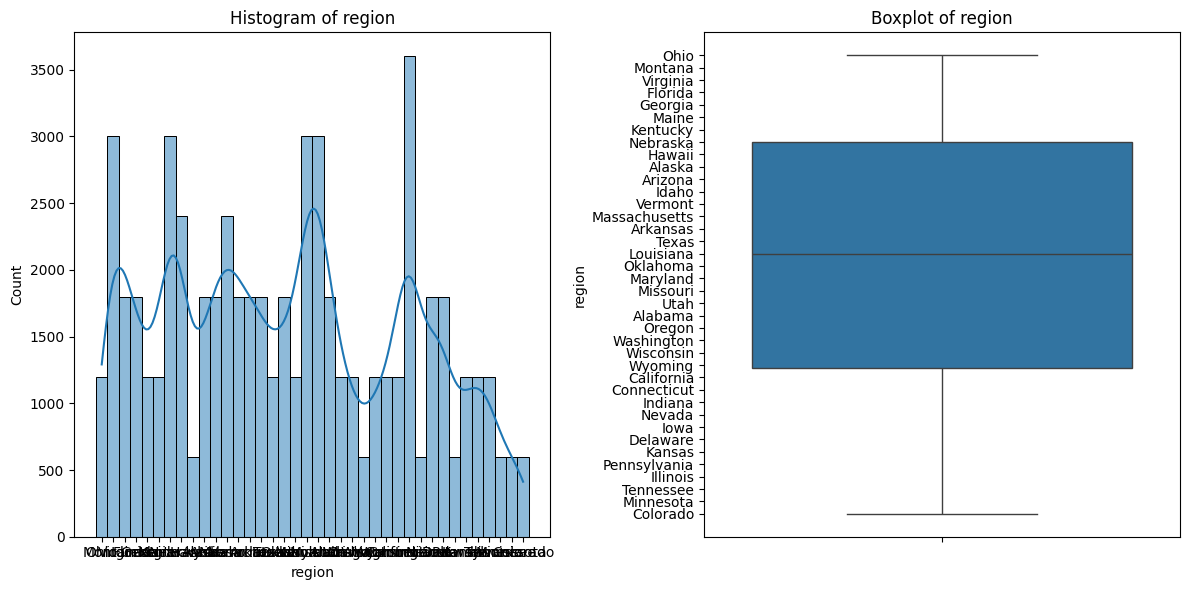

In [16]:
descriptive_statistics(df)
univariate_analysis(df, 'region')

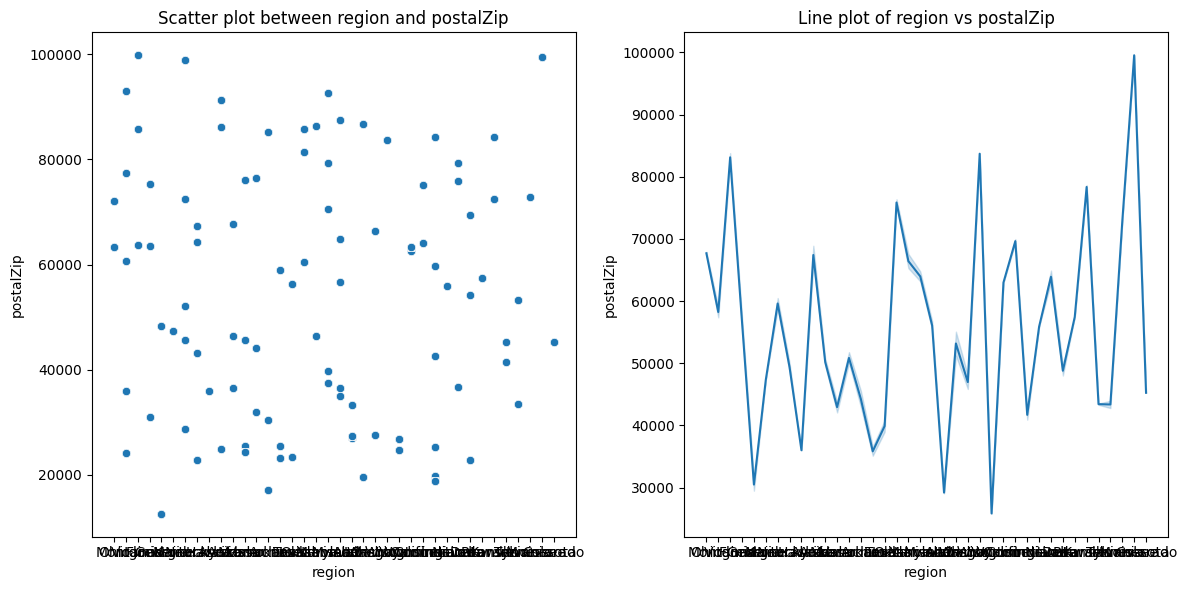

In [17]:
bivariate_analysis(df, 'region', 'postalZip')

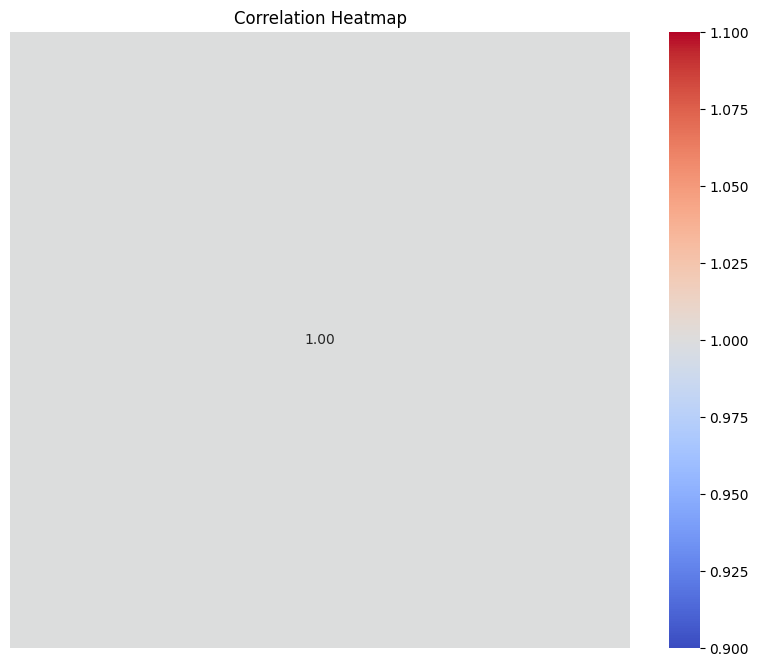

In [27]:
correlation_analysis(df)


Missing Value Analysis:
name               0
phone              0
address            0
postalZip          0
region             0
appointmentdate    0
dtype: int64


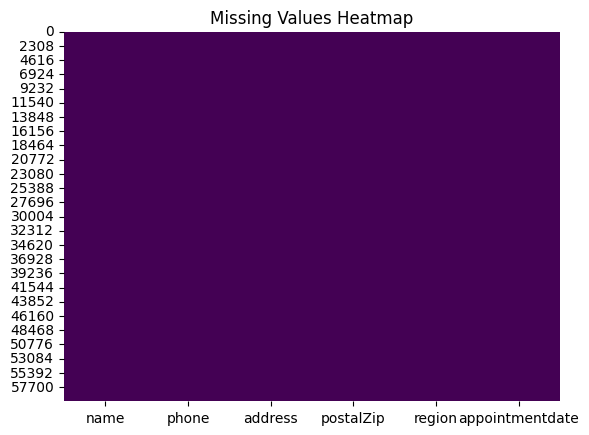

In [28]:
missing_value_analysis(df)